# **AUTOMATIZADOR DE PROGRAMACIÓN QUIRÚRGICA**
Prácticas Externas 1 (Prácticas Clínicas)

Universidad Rey Juan Carlos

Irene Raven García


Se ha decidido implementar un algoritmo genético, como método de optimización heurístico.
A continuación, se muestra con mayor detalle los pasos a seguir para obtener el resultado óptimo deseado.

En primer lugar, se importan las librerías necesarias.

In [1]:
import numpy as np
import random
import csv
from datetime import timedelta, date, datetime
import matplotlib.pyplot as plt


A continuación, se crea la clase Person, para así facilitar el uso posterior de las variables que sean de interés.

In [2]:
class Person:
    def __init__(self, nhc, cod, cip, edad, telefono1, telefono2, aptoANR, asa, fechaANR, SERV_INT, media_tiempo, C1, desDX1, codDX2, desDX2, P1, desP1, codP2, desP2, alergias, observaciones, tqe, numTqe, tmTqe, ingreso, tL1, tL2, tL3, fechaLimite, covid):
        self.nhc = nhc
        self.cod = cod
        self.cip = cip
        self.edad = edad
        self.telefono1 = telefono1
        self.telefono2 = telefono2
        self.aptoANR = aptoANR
        self.asa = asa 
        self.fechaANR = fechaANR
        self.SERV_INT = SERV_INT
        self.media_tiempo = media_tiempo
        self.C1 = C1
        self.desDX1 = desDX1
        self.codDX2 = codDX2
        self.desDX2 = desDX2
        self.P1 = P1
        self.desP1 = desP1
        self.codP2 = codP2
        self.desP2 = desP2
        self.alergias = alergias
        self.observaciones = observaciones
        self.tqe = tqe 
        self.numTqe = numTqe
        self.tmTqe = tmTqe
        self.ingreso = ingreso
        self.tL1 = tL1
        self.tL2 = tL2
        self.tL3 = tL3
        self.fechaLimite = fechaLimite
        self.covid = covid

Se crea la definición servicio para poder obtener la lista de pacietes únicamente del servicio en el que se desea buscar al individuo más óptimo.

In [4]:
def servicio(doc,serv_type):

    pac=[]
    pacientes=[]

    file = open(doc,"r")
    datos=file.readline()
    first_line=datos.split(',')
  
    for lin in file: 
        linea=np.array(lin.split(';'))
        pacientes+=[Person(linea[0],linea[1],linea[2],linea[3],linea[4],linea[5],linea[6],linea[7],linea[8],linea[9],linea[10],linea[11],linea[12],linea[13],linea[14],linea[15],linea[16],linea[17],linea[18],linea[19],linea[20],linea[21],linea[22],linea[23],linea[24],linea[25],linea[26],linea[27],linea[28],linea[29])]
        if pacientes[-1].SERV_INT==serv_type:
            pac+=[pacientes[-1]]

    return pac

Además, se crea una función que calcule la diferencia en días entre dos fechas.

In [5]:
def diasHastaFecha(date1, date2):
    day1=datetime.strptime(date1,"%d/%m/%Y")
    day2=datetime.strptime(date2,"%d/%m/%Y")
    return ((day2-day1).days)

A continuación, se crea la función *idoneo*. En esta, se calcula la **función de idoneidad** del individuo a partir del tiempo libre restante de la sesión, y del sumatorio de las diferencias, en días, entre la fecha límite de cada paciente, con la fecha asignada para el individuo.

In [6]:
def idoneo (individuo, fecha_ingreso, min_sesion, pac_serv): 
 
    tiempo_libre=0
    duracion=0
    suma_dif=0

    for i in individuo:
        for j in pac_serv:
            if j.nhc == i:
                duracion+=int(j.media_tiempo)
                fecha_limite=j.fechaLimite
                suma_dif+=min([diasHastaFecha(fecha_ingreso,fecha_limite),180])

    t_libre = min_sesion - duracion
    f_idoneidad= (suma_dif + 10*t_libre)
    return f_idoneidad 

Posteriormente, se crea la función creación. En esta, se originará la **primera generación**. Para ello, se generan 10000 individuos, de forma que, en la formación de cada uno de ellos, se elige un número de forma aleatoria, y se selecciona al paciente de la lista de espera que se encuentre en dicha posición. Se comprueba que no haya sido seleccionado con anterioridad, así como, que entre en el tiempo de la sesión. Si es así, se añade a la lista de pacientes de dicho individuo, y si no, se repite el proceso desde seleccionar un número aleatorio, con un máximo de 30 intentos.

Además, se calcula la idoneidad para cada individuo.



In [7]:
def creacion(fecha_ingreso, min_sesion, pac_serv): 

    idoneidad=[]
    generacion=[]
    lista=[]

    for i in range(0,10000):
        suma_dif=0
        count=0
        individuo=[]
        historial_pacientes=[]
        sesion=0

        while count<30:
            num=random.randint(0,len(pac_serv)-1) 
            paciente_seleccionado = pac_serv[num]
            nhc_paciente = paciente_seleccionado.nhc

            if nhc_paciente not in historial_pacientes: 
                duracion=int(paciente_seleccionado.media_tiempo)       
                if duracion+sesion<=min_sesion:
                    individuo+=[nhc_paciente]
                    sesion+=duracion
                   
                historial_pacientes+=[nhc_paciente]
            count+=1

        idoneidad+=[idoneo(individuo, fecha_ingreso, min_sesion, pac_serv)]
        generacion += [individuo]

    lista=[]
    for i in range(0,10000):
        lista+=[[idoneidad[i],generacion[i][:]]]

    return lista #Aqui se devuelve una lista, formada a su vez por otras dos listas, idoneidad y generacion. 

Después, se ha diseñado la función *seleccion*, con el fin de que se seleccione el 30% de los individuos con mejor idoneidad. Para ello se ordena la lista basándose en el valor obtenido en la función de idoneidad, y posteriormente se recoge únicamente el 30% de esta.

In [8]:
def seleccion(generacion_anterior, pac_serv, min_sesion):
    lista=sorted(generacion_anterior)  
    seleccion_generacion=lista[0:int(30*len(generacion_anterior)/100)]

    return seleccion_generacion

También se ha definidio  *cruzamiento*. En esta definición se determina que, a partir del mejor 30% de la última generación obtenida, se seleccionan dos individuos aleatorios, y se intercambia un paciente de cada uno de ellos.

De tal forma que, al comprobar las nuevas duraciones de las cirugías programadas, si la duración de la sesión con el nuevo conjunto de pacientes es correcta, se denomina a los nuevos individios **generación hija**.

Además, si es posible añadir, de forma extra, a algún paciente de la lista de espera original del servicio, se añade como **mutación** , definición que se define a continuación de esta.

In [10]:
def cruzamiento (seleccion_generacion, pac_serv, min_sesion):
  
    siguiente_generacion=seleccion_generacion

    while (len(siguiente_generacion)<10000):
        par_ind = random.choices(siguiente_generacion, k=2) #Aqui se seleciconan de forma aleatoria dos individuos (grupo de pac) de la lista. 
        index1 = random.randint(0,len(par_ind[0][1])-1) #Se selecciona el indice del primer grupo.
        index2 = random.randint(0,len(par_ind[1][1])-1) #Se selecciona el indice del segundo grupo.
        nhc1=par_ind[0][1][index1]  #Se coge el codigo del paciente en el indice seleccionado del primer grupo.
        nhc2=par_ind[1][1][index2]  #Igual con el del otro grupo
        duracion1=0
        duracion2=0
        for i in pac_serv:
            for j in par_ind[0][1]:
                if j==i.nhc:
                    duracion1+=int(i.media_tiempo)
            for k in par_ind[1][1]:
                if k==i.nhc:
                    duracion2+=int(i.media_tiempo)
    
        par_ind_temp=par_ind  #Se genera de forma temporal el nuevo par de individuos, con el fin de hacer el cruce. (Se genera temporal por si es invalido no perder el anterior).
        par_ind_temp[0][1][index1]=nhc2 #Se produce el cruce. Se introduce en la posicion en la que estaba el pac1 dentro del grupo1, el paciente 2.
        par_ind_temp[1][1][index2]=nhc1 #Y viceversa

        #A continuacion, compruebo si las duraciones de los nuevos pacientes me entran en el tiempo determinado de la sesion.
        nueva_duracion1=0
        nueva_duracion2=0

        for i in pac_serv:
            for j in par_ind_temp[0][1]:
                if j==i.nhc: 
                    nueva_duracion1+=int(i.media_tiempo) 
            for j in par_ind_temp[1][1]:
                if j==i.nhc:
                    nueva_duracion2+=int(i.media_tiempo)

            if nueva_duracion1<min_sesion and nueva_duracion2<min_sesion:   #Si me entra EN LOS DOS GRUPOS
              #confirmamos que es nueva generacion 
              [par_ind_temp[0],duracion_final1]=mutacion(par_ind_temp[0], fecha_ingreso, min_sesion, pac_serv)
              [par_ind_temp[1],duracion_final2]=mutacion(par_ind_temp[1], fecha_ingreso, min_sesion, pac_serv)
              par_ind_temp[0][0]=idoneo(par_ind_temp[0][1], fecha_ingreso, min_sesion, pac_serv)
              par_ind_temp[1][0]=idoneo(par_ind_temp[1][1], fecha_ingreso, min_sesion, pac_serv)
              siguiente_generacion+=[par_ind_temp[0]]
              siguiente_generacion+=[par_ind_temp[1]]

        return siguiente_generacion

In [11]:
#Y hacemos las mutaciones. Es decir, miramos si entra algun paciente nuevo (extra).
def mutacion(individuo, fecha_ingreso, min_sesion, pac_serv):
    max_tiempo_libre=50
    duracion=0
    for i in pac_serv:
        for j in individuo[1]:
            if j == i.nhc:
                duracion+=int(i.media_tiempo)
    temp_libre=min_sesion-duracion
    duracion_final=duracion
    n=0
    while (temp_libre >= 0) and (n<1000 or temp_libre>max_tiempo_libre):
        num=random.randint(0,len(pac_serv)-1) 
        paciente_seleccionado = pac_serv[num]
        n+=1
        if (paciente_seleccionado.nhc not in individuo[1]) and (temp_libre-int(paciente_seleccionado.media_tiempo)>=0):
            individuo[1]+=[paciente_seleccionado.nhc]
            temp_libre=temp_libre-int(paciente_seleccionado.media_tiempo)
            duracion_final=min_sesion-temp_libre

    return individuo, duracion_final

Por último, se pide al usuario que introduzca los valores de cada una de las variables con las que se desea trabajar, se carga la base de datos correspondiente y se generan varias generaciones nuevas con el fin de optimizar el resultado final.

In [28]:
condicion=True

while condicion:
    try:
        fecha_ingreso = input("Introduzca la fecha en la que se desea llevar a cabo las cirugías (dd/mm/YYYY):") 
        min_sesion = int(input("Introduzca la cantidad de minutos de la que desea calcular la sesion:"))
        pac_serv_type = (input("Introduzca el servicio con el que desee trabajar (la abreviatura):")).upper() 
        condicion=False
    except ValueError:
        print("\nLo siento, ha introducido un valor erróneo. Por favor vuélvalo a intentar.")

    pac_serv=servicio('pacientes.csv',pac_serv_type)

    generacion = creacion(fecha_ingreso, min_sesion, pac_serv)
    seleccion_generacion=seleccion(generacion, pac_serv, min_sesion)
    nuevageneracion= cruzamiento(seleccion_generacion, pac_serv, min_sesion)
    seleccion_generacion2=seleccion(nuevageneracion, pac_serv, min_sesion)
    

    print('\033[1m'+"\n\n Los pacientes seleccionados del servicio,"+'\033[0;0m',pac_serv_type)
    print( '\033[1m'+"para ser operados el día"+'\033[0;0m', fecha_ingreso)
    print( '\033[1m'+"son aquellos con el nhc:"+'\033[0;0m', seleccion_generacion2)


Introduzca la fecha en la que se desea llevar a cabo las cirugías (dd/mm/YYYY):20/10/2020
Introduzca la cantidad de minutos de la que desea calcular la sesion:420
Introduzca el servicio con el que desee trabajar (la abreviatura):cgd


 Los pacientes seleccionados del servicio, CGD
para ser operados el día 20/10/2020
son aquellos con el nhc: [[275, ['466996', '861050', '669428']], [286, ['79711', '466996']], [314, ['556242', '893629', '906992']], [315, ['556242', '991092', '447195']], [345, ['439806', '466996', '923111']], [359, ['439806', '90784', '38848']], [362, ['80542', '536631', '990648']], [373, ['893629', '683723', '973557']], [374, ['447195', '431229', '973557']], [380, ['102724', '367257']], [380, ['440658', '523285']], [389, ['94294', '556242', '979713']], [390, ['556242', '530469', '683723']], [400, ['556242', '367257']], [400, ['74500', '923791']], [400, ['907116', '923791']], [410, ['93294', '556242', '440658']], [412, ['536454', '439806', '536631']], [413, ['79711', '4900

## Representación de los valores obtenidos

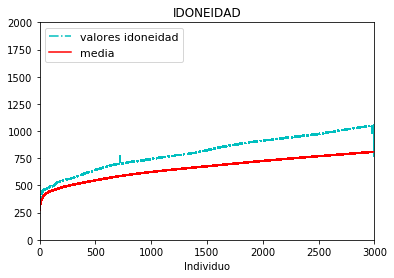

In [29]:
valores_idoneidad=[]
media=[]
for i in seleccion_generacion:
    valores_idoneidad+=[i[0]]
    plt.plot(valores_idoneidad, 'c-.')
    media+=[np.mean(valores_idoneidad)]
    plt.plot(media, "r-")

plt.xlim(0,3000)
plt.ylim(0,2000)
plt.title('IDONEIDAD')
plt.xlabel("Individuo")
plt.legend(('valores idoneidad', 'media'), prop = {'size': 11}, loc='upper left')

plt.show()